In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

from scipy.optimize import root_scalar

from joblib import dump, load

from expon_mixture import ExponMixture 

In [2]:
fits = pd.read_csv('./fits/expon_mix_2comp_fits.txt', index_col=0)

In [3]:
fits[fits['p1']<1.0].describe()

,p1,p2,lambda1,lambda2
count,158.000000,158.000000,1.580000e+02,1.580000e+02
mean,0.145675,0.854325,3.613421e+07,2.132482e+09
std,0.299654,0.299654,4.188702e+08,1.239764e+10
min,0.003333,0.003333,1.800000e+01,4.599383e+02
25%,0.013333,0.933333,1.117500e+02,3.081959e+05
50%,0.023333,0.976667,2.767045e+02,3.456719e+06
75%,0.066667,0.986667,7.069048e+02,5.270312e+07
max,0.996667,0.996667,5.248641e+09,1.305466e+11


In [4]:
fits

,p1,p2,lambda1,lambda2
instance,,,,
barthel/n210/gen_n210_m903_k3SAT_seed2473397791.cnf,1.000000,NaN,3.214107e+03,NaN
barthel/n210/gen_n210_m903_k3SAT_seed862748622.cnf,1.000000,NaN,1.342518e+04,NaN
barthel/n210/gen_n210_m903_k3SAT_seed4006075830.cnf,1.000000,NaN,1.295157e+03,NaN
barthel/n210/gen_n210_m903_k3SAT_seed1547818438.cnf,1.000000,NaN,1.365623e+03,NaN
barthel/n210/gen_n210_m903_k3SAT_seed3919912883.cnf,1.000000,NaN,1.511253e+03,NaN
...,...,...,...,...
qhid/n70/gen_n70_m385_k3SAT_seed2030441879.cnf,1.000000,NaN,3.993567e+02,NaN
qhid/n70/gen_n70_m385_k3SAT_seed3717411169.cnf,1.000000,NaN,2.097433e+02,NaN
qhid/n70/gen_n70_m385_k3SAT_seed684617509.cnf,1.000000,NaN,2.370867e+02,NaN


In [5]:
df = pd.read_csv('./calculate_features/features_train.csv')
df.set_index('instance', inplace=True)

In [6]:
df.head()

,nvarsOrig,nclausesOrig,nvars,nclauses,reducedVars,reducedClauses,Pre-featuretime,vars-clauses-ratio,POSNEG-RATIO-CLAUSE-mean,POSNEG-RATIO-CLAUSE-coeff-variation,...,gsat_FirstLocalMinStep_Q.10,gsat_FirstLocalMinStep_Q.90,gsat_BestAvgImprovement_Mean,gsat_BestAvgImprovement_CoeffVariance,gsat_FirstLocalMinRatio_Mean,gsat_FirstLocalMinRatio_CoeffVariance,ls-gsat-featuretime,lobjois-mean-depth-over-vars,lobjois-log-num-nodes-over-vars,lobjois-featuretime
instance,,,,,,,,,,,,,,,,,,,,,
barthel/n210/gen_n210_m903_k3SAT_seed3555821415.cnf,210.0,903.0,199.0,892.0,0.055276,0.012332,0.0,0.223094,0.488565,0.604264,...,39.0,52.0,0.566566,0.415860,0.857284,0.050368,2.72,0.388437,0.765035,1.14
barthel/n210/gen_n210_m903_k3SAT_seed862748622.cnf,210.0,903.0,203.0,897.0,0.034483,0.006689,0.0,0.226310,0.493683,0.586009,...,40.0,53.0,0.550169,0.417447,0.849422,0.054019,2.72,0.365887,0.719841,1.10
barthel/n210/gen_n210_m903_k3SAT_seed3576518490.cnf,210.0,903.0,204.0,892.0,0.029412,0.012332,0.0,0.228700,0.501121,0.583115,...,40.0,53.0,0.554184,0.416429,0.858623,0.049907,2.62,0.365476,0.700129,1.12
barthel/n210/gen_n210_m903_k3SAT_seed2527888016.cnf,210.0,903.0,201.0,894.0,0.044776,0.010067,0.0,0.224832,0.495153,0.609906,...,40.0,53.0,0.579225,0.412855,0.860000,0.051025,2.66,0.386035,0.933892,1.16
barthel/n210/gen_n210_m903_k3SAT_seed3919912883.cnf,210.0,903.0,205.0,897.0,0.024390,0.006689,0.0,0.228540,0.487737,0.589016,...,40.0,53.0,0.563700,0.410805,0.863640,0.048454,2.70,0.383312,0.786043,1.16


In [7]:
merged_data = pd.concat([df, fits], join='inner', axis=1)

In [8]:
v2 = merged_data[merged_data['p1']<1.0]
y = v2[['p1', 'lambda1', 'lambda2']]
X = v2.drop(['p1', 'p2', 'lambda1', 'lambda2'], axis=1)

In [9]:
regr_rf = RandomForestRegressor()
regr_rf.fit(X, y)

RandomForestRegressor()

In [10]:
dump(regr_rf, 'rf_regressor.joblib') 

['rf_regressor.joblib']

In [11]:
regr_rf = load('rf_regressor.joblib') 

In [12]:
regr_rf.predict(X)

array([[7.96000000e-01, 2.22295993e+05, 5.87076175e+07],
       [8.06266667e-01, 5.43353307e+03, 1.46668040e+08],
       [2.71666667e-01, 8.37449970e+03, 1.30121529e+08],
       [7.33333333e-01, 3.23094458e+04, 1.52920643e+08],
       [6.83900000e-01, 2.60697358e+03, 1.64084630e+10],
       [8.63166667e-01, 1.77894549e+05, 2.66595248e+08],
       [7.97233333e-01, 6.82168317e+04, 1.91643687e+08],
       [2.52800000e-01, 3.49509706e+04, 1.26338489e+08],
       [8.78266667e-01, 1.15898368e+04, 2.51900407e+07],
       [7.11133333e-01, 8.52958218e+03, 8.28839075e+08],
       [7.56133333e-01, 2.09148242e+04, 3.08425385e+09],
       [3.33566667e-01, 1.59247755e+04, 4.83699194e+07],
       [7.73800000e-01, 4.43531624e+04, 2.88360475e+08],
       [8.12700000e-01, 3.99705517e+04, 1.44170664e+08],
       [9.02733333e-01, 2.19156966e+04, 2.16029499e+07],
       [3.27333333e-02, 8.83589996e+03, 5.56211493e+07],
       [2.77000000e-02, 5.24868235e+07, 1.35542513e+10],
       [8.73333333e-03, 5.73754

In [13]:
estimators = [('variance_removal', VarianceThreshold(0.08)), ('random_forest', RandomForestRegressor(max_features=0.1, n_estimators=5, random_state=1))]
pipe = Pipeline(estimators)
transformed_regressor = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())

In [14]:
transformed_regressor.fit(X,y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('variance_removal',
                                                      VarianceThreshold(threshold=0.08)),
                                                     ('random_forest',
                                                      RandomForestRegressor(max_features=0.1,
                                                                            n_estimators=5,
                                                                            random_state=1))]),
                           transformer=MinMaxScaler())

In [15]:
dump(transformed_regressor, 'rf_agressive.joblib') 

['rf_agressive.joblib']

In [16]:
transformed_regressor = load('rf_agressive.joblib') 

In [17]:
transformed_regressor.predict(X)

array([[9.96666667e-01, 3.34808351e+05, 3.20706200e+06],
       [9.62666667e-01, 1.37522981e+05, 1.30131620e+06],
       [6.00000000e-02, 9.74833333e+02, 3.67400248e+04],
       [5.55333333e-01, 7.06927152e+04, 6.72484794e+05],
       [7.41333333e-01, 4.93235348e+03, 3.49687893e+04],
       [6.12666667e-01, 1.35587621e+05, 1.30511341e+06],
       [7.78000000e-01, 2.08142694e+04, 3.09406463e+05],
       [2.24000000e-01, 2.52871587e+03, 6.28191256e+05],
       [9.90000000e-01, 2.47588889e+03, 1.74056667e+04],
       [9.70000000e-01, 5.45093059e+03, 3.32998416e+04],
       [9.67333333e-01, 4.83813359e+03, 2.91240545e+04],
       [3.28666667e-01, 2.48145889e+03, 2.97758695e+04],
       [9.46666667e-01, 6.36084210e+03, 3.50857000e+04],
       [8.04666667e-01, 2.76583357e+04, 1.55631153e+05],
       [9.76666667e-01, 6.90060326e+03, 4.30888000e+04],
       [6.33333333e-02, 8.35602159e+03, 4.22163298e+06],
       [1.60000000e-02, 3.67771429e+02, 1.72607411e+09],
       [3.33333333e-03, 5.28200

In [32]:
from sklearn.tree import export_text, export_graphviz

In [33]:
eps = 0.08
v2 = merged_data[merged_data['p1']<1.0]
y = v2[['p1', 'lambda1', 'lambda2']]
X = v2.drop(['p1', 'p2', 'lambda1', 'lambda2'], axis=1)
sel = VarianceThreshold(eps)
sel.fit(X)
X_new = pd.DataFrame(sel.transform(X), index=X.index, columns=X.columns[sel.get_support()])
scaler = MinMaxScaler().fit(y)
y_new = pd.DataFrame(scaler.transform(y), index=y.index, columns=['p1', 'lambda1', 'lambda2'])

rf = RandomForestRegressor(max_features=0.1, n_estimators=5, random_state=1)
rf.fit(X_new, y_new)

In [39]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


In [44]:
print("Feature ranking:")

for f in range(X_new.shape[1]):
    print(f"{f+1}. {X_new.columns[indices[f]]}, {importances[indices[f]]}")

Feature ranking:
1. saps_FirstLocalMinStep_Mean, 0.16719578228221663
2. saps_BestSolution_Mean, 0.14781006634416557
3. ls-gsat-featuretime, 0.1185536843790352
4. gsat_BestSolution_Mean, 0.09654081923069154
5. gsat_FirstLocalMinStep_Q.10, 0.09158911117377946
6. nvarsOrig, 0.09007585669808625
7. nvars, 0.08693480044063501
8. gsat_FirstLocalMinStep_Mean, 0.05466938516658408
9. nclauses, 0.045229973773601675
10. ls-saps-featuretime, 0.02262335509393897
11. saps_FirstLocalMinStep_Q.90, 0.02000280233562566
12. gsat_FirstLocalMinStep_Median, 0.01769988883623899
13. saps_FirstLocalMinStep_Q.10, 0.016970573661669087
14. saps_FirstLocalMinStep_Median, 0.009949861211421452
15. nclausesOrig, 0.00873285545017886
16. gsat_FirstLocalMinStep_Q.90, 0.00542118392213152


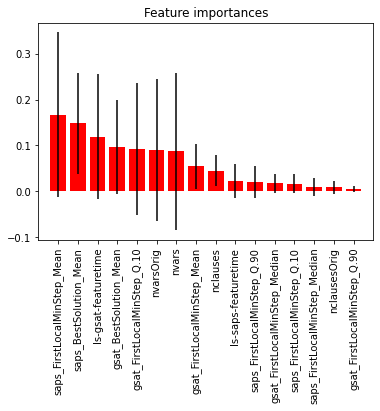

In [49]:
import matplotlib.pyplot as plt 

names = X_new.columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_new.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_new.shape[1]), names, rotation='vertical')
plt.xlim([-1, X_new.shape[1]])
plt.show()

In [50]:
from sklearn.inspection import permutation_importance

In [62]:
result = permutation_importance(rf, X_new, y_new, n_repeats=100, random_state=0)
indices = np.argsort(result.importances_mean)[::-1]

In [63]:
print("Feature ranking:")

for f in range(X_new.shape[1]):
    print(f"{f+1}. {X_new.columns[indices[f]]}, {result.importances_mean[indices[f]]}")

Feature ranking:
1. saps_BestSolution_Mean, 0.23646769409938706
2. gsat_BestSolution_Mean, 0.20126931996373035
3. nvarsOrig, 0.1836806778729077
4. saps_FirstLocalMinStep_Q.90, 0.14427325911570252
5. gsat_FirstLocalMinStep_Median, 0.12896545049991698
6. ls-saps-featuretime, 0.12854418201636447
7. nclausesOrig, 0.12850309029777177
8. gsat_FirstLocalMinStep_Mean, 0.1268868390612396
9. nclauses, 0.12173307634116697
10. gsat_FirstLocalMinStep_Q.90, 0.10469716951909168
11. gsat_FirstLocalMinStep_Q.10, 0.10269931122372729
12. saps_FirstLocalMinStep_Mean, 0.08685930148251965
13. saps_FirstLocalMinStep_Q.10, 0.0698496544322721
14. ls-gsat-featuretime, 0.04764054226054034
15. nvars, 0.038881567405090925
16. saps_FirstLocalMinStep_Median, 0.002655633946730771


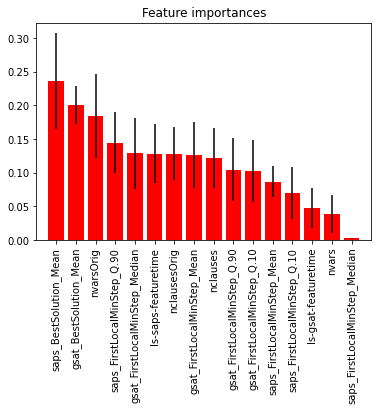

In [64]:
names = X_new.columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_new.shape[1]), result.importances_mean[indices],
        color="r", yerr=result.importances_std[indices], align="center")
plt.xticks(range(X_new.shape[1]), names, rotation='vertical')
plt.xlim([-1, X_new.shape[1]])
plt.show()